# 第7章 アンサンブル学習

* 多数決に基づく予測
* トレーニングデータセットのランダムな組み合わせを繰り返し抽出することによる過学習の抑制
* 誤答から学習する「弱学習器」による強力なモデルの構築

## 7.1 アンサンブルによる学習

* アンサンブル法(ensemble method)
* 多数決(majority voting)
* 相対多数決(plurality voting)

In [1]:
from IPython import display

from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

In [2]:
# 誤分類率を計算する
from scipy.misc import comb
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    # print(k_start) # 6
    
    probs = []
    for k in range(k_start, n_classifier + 1): # 6 to 11
        # print(k, comb(n_classifier, k))
        probs.append(comb(n_classifier, k) * error ** k * (1 - error) ** (n_classifier - k))

    #print(probs)
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

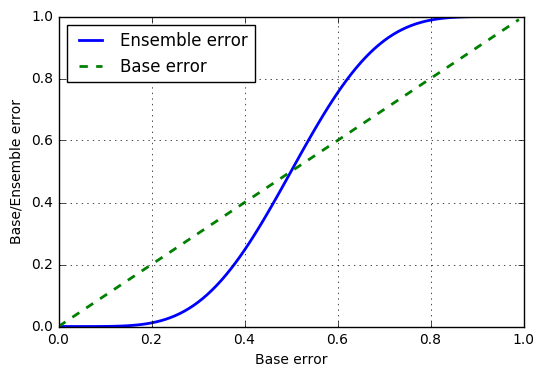

In [3]:
import numpy as np
error_range = np.arange(0.0, 1.0, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

import matplotlib.pyplot as plt
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, label='Base error', linewidth=2, linestyle='--')
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## 7.2 単純な多数決分類機の実装

* 特性関数(charasteristic function): Χ(カイ)
* 重み付け(weighting)

In [4]:
import numpy as np
# クラスラベルが 0, 0, 1
# 重み係数が 0.2, 0.2 0.6
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

In [5]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
# それぞれのクラスに所属する確率
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
# 多数決の結果
print(np.argmax(p))

[ 0.58  0.42]
0


In [6]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    多数決アンサンブル分類器
    
    パラメータ
    ----------
    classifiers : array-like, shape = [n_classifiers]
        アンサンブルの様々な分類器
        
    vote : str, {}'classlabel', 'probability'} {default: 'classlabel}
        'classlabel' の場合、クラスラベルの予測はクラスラベルのargmaxに基づく
        'probability' の場合、クラスラベルの予測はクラスの所属確率のargmaxに基づく(分類器が調整済であることが推奨される)
        
    weights : array-like, shape = [n_classifiers] (optional, default=None)
        `int` または `float` 型の値のリストが提供された場合、分類器は重要度で重み付けされる
        `weights=None` の場合は均一な重みを使用
        
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """
        分類機を学習させる
        
        パラメータ
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            トレーニングサンプルからなる行列
            
        y : array-like, shape = [n_samples]
            クラスラベルのリスト
        
        戻り値
        ------
        self : object
        """
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """
        Xのクラスラベルを予測する
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.array_along_axis(
                lambda x:
                np.argmax(np.bincount(x, weights=self.weights)),
                axis=1,
                arr=predictions
            )
            
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """
        Xのクラス確率を予測する
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        arg_proba = np.average(probas, axis=0, weights=self.weights)
        return arg_proba
    
    def get_params(self, deep=True):
        """
        GridSearchの実行時に分類器のパラメータ名を取得
        """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['{}_{}'.format(name, key)] = value
            return out

### 7.2.1 多数決方式の分類アルゴリズムを組み合わせる

In [7]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data[50:, [1, 2]]
y = iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
# 50% のトレーニングデータと 50% のテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=1)

In [9]:
# ロジスティック回帰、決定木、k近傍をそれぞれつかって分類
# 10分割交差検証を使う
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import cross_val_score
else:
    from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clfs = [pipe1, clf2, pipe3]
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

for clf, label in zip(clfs, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: {:.2f} (+/- {:.2f}) [{}]'.format(scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [10]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clfs.append(mv_clf)
clf_labels.append('Majority Voting')

for clf, label in zip(clfs, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: {:.2f} (+/- {:.2f}) [{}]'.format(scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


## 7.3 アンサンブル分類器の評価とチューニング

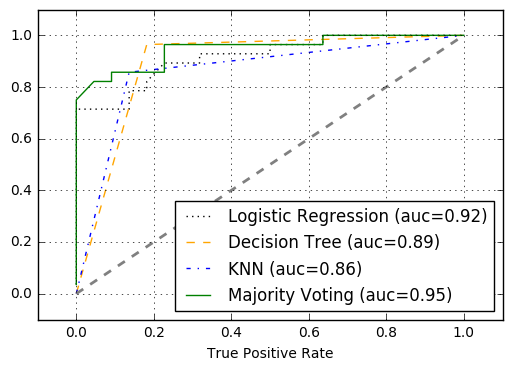

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(clfs, clf_labels, colors, linestyles):
    # 陽性クラスのラベルは1であることが前提
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='{} (auc={:.2f})'.format(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.show()

In [12]:
from itertools import product
import numpy as np

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
# 決定領域を描画する最小値、最大値を生成
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
print(x_min, x_max, y_min, y_max)
# グリッドポイントを生成
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y.min, y.max, 0.1))
# 描画領域を2行2列に分割
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))


-3.07478920904 2.55939571126 -2.79369815479 3.32448638427
